In [1]:
%load_ext autoreload
%autoreload 2

### plotting setup

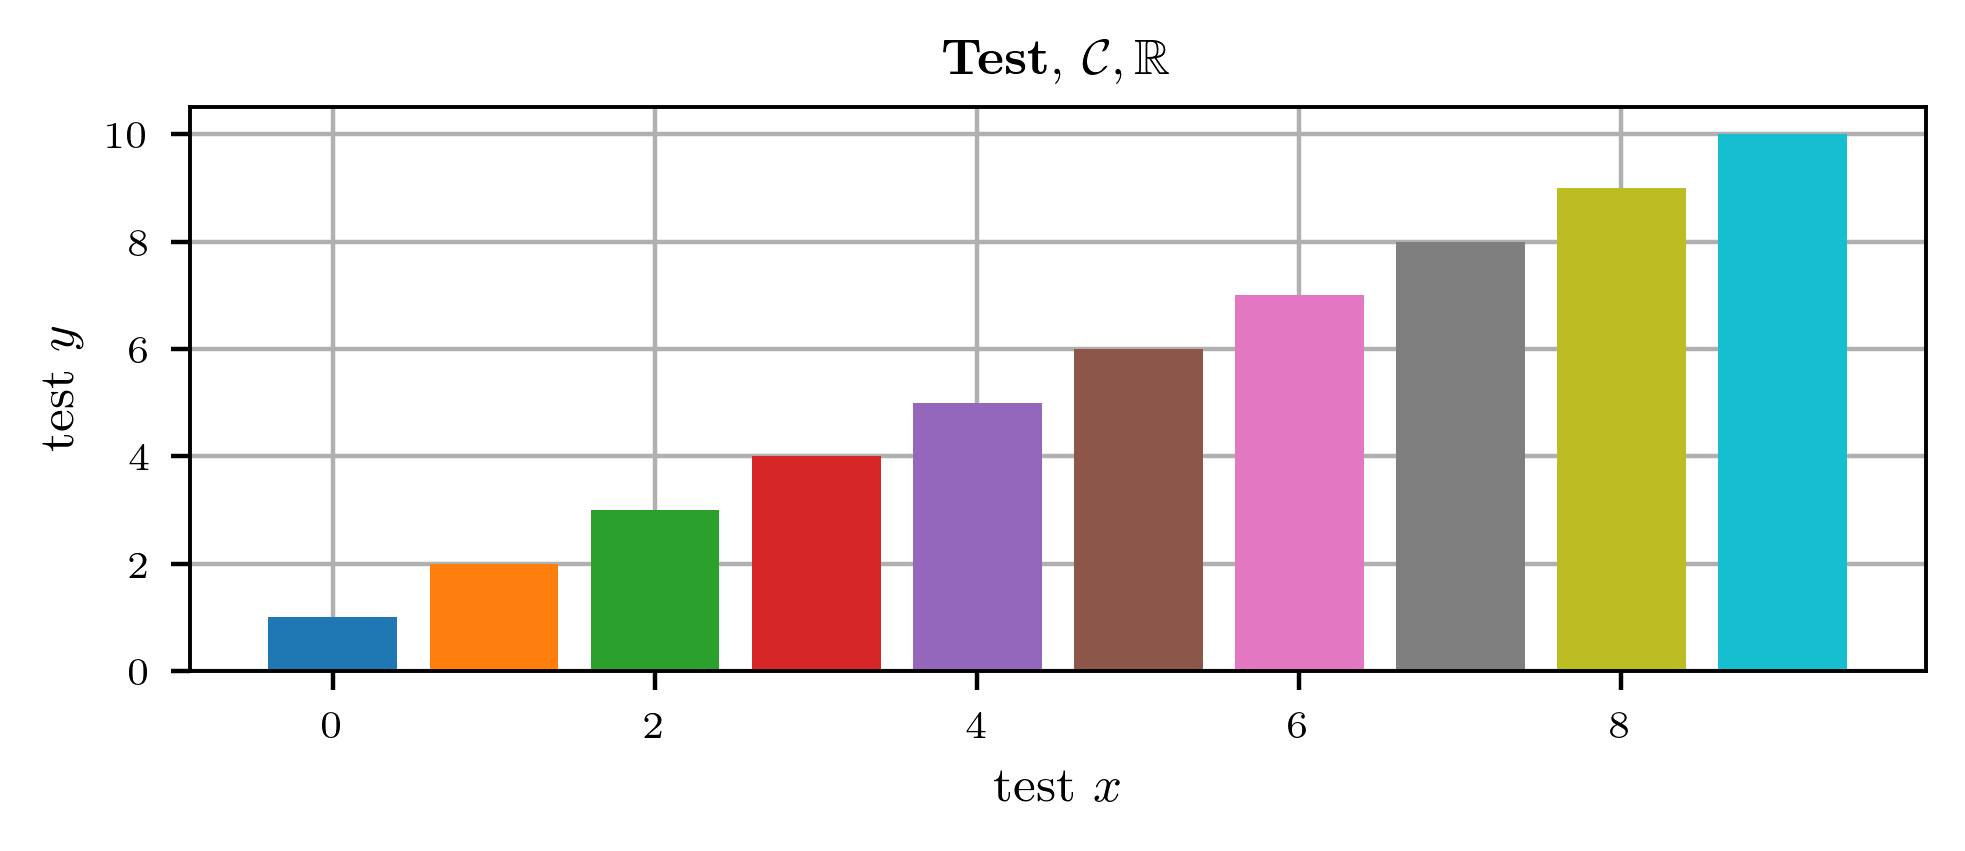

In [2]:
import matplotlib
# matplotlib.use('pgf')

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline


c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

markerlist = ['o', 4, 5, 6, 7, 'p', 'd', 'P']


text_width = 5.60107  # in  --> Confirmed with template explanation

fs_m1 = 7  # for figure ticks
fs = 9  # for regular figure text
fs_p1 = 10  # figure titles

axes_lw = 0.7

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('axes', linewidth=axes_lw)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title


matplotlib.rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})

matplotlib.rc('text', usetex=True)

plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsfonts}'})

# Test setup

plt.figure(dpi=400, figsize=(text_width, text_width/3))
plt.grid(0.3, zorder=0)
for i in range(10):
    plt.bar(i, i + 1, color=f'C{i}', zorder=2)
    # ^ This zorder nonsense makes the grid  lines go behid the bars. I don't know why this is needed for barplots, but shouldn't usually be needed.
plt.title(r'\textbf{Test}, $\mathcal{C}, \mathbb{R}$')
plt.xlabel('test $x$')
plt.ylabel('test $y$')
plt.show()

# Define errorfill


def errorfill(x, y, yerr, color=None, alpha_fill=0.3, line_alpha=1, ax=None,
              lw=1, linestyle='-', fill_linewidths=0.2,
              marker=None, markersize=1, label=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    plt_return = ax.plot(x, y, color=color, lw=lw, linestyle=linestyle, alpha=line_alpha, label=label, marker=marker, markersize=markersize)
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill, linewidths=fill_linewidths)
    return plt_return


## package imports

In [3]:

import jax
from jax import jit, vmap
from functools import partial
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scalable_gps
from scalable_gps import data
from scalable_gps.kernels import RBFKernel, Matern32Kernel
from scalable_gps.models.exact_gp_model import ExactGPModel
from scalable_gps.models.sgd_gp_model import SGDGPModel
from scalable_gps.models.inducing_sgd_gp_model import ISGDGPModel

import ml_collections



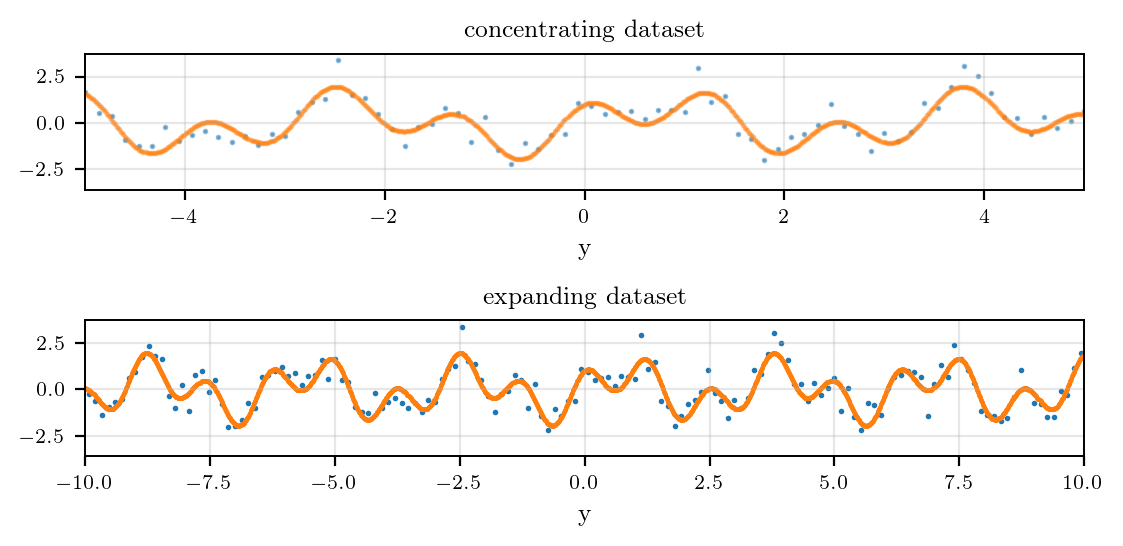

In [42]:


## Generate Data

noise_scale = 0.5
n_data = 10000
n_test = 1000
seed = 3

concentrate_data_train, concentrate_data_test = data.get_concentrating_toy_sin_dataset(
    seed=seed,
    n=n_data,
    noise_scale=noise_scale,
    n_test=n_test,
    x_std = 1.0,
    normalise=False
)



data_train, data_test = data.get_expanding_toy_sin_dataset(
    seed=seed,
    n=n_data,
    noise_scale=noise_scale,
    n_test=n_test,
    n_periods = 15,
    normalise=False
)

fig, ax = plt.subplots(2,1, figsize=(text_width,text_width/2), dpi=200)

ax[0].scatter(data_train.x, data_train.y,  1, alpha=0.5, c=c[0])
ax[0].scatter(concentrate_data_test.x, concentrate_data_test.y,  1, alpha=0.5, c=c[1])
ax[0].set_xlabel('x')
ax[0].set_xlabel('y')
ax[0].grid(alpha=0.3)
ax[0].set_xlim([-5,5])
ax[0].set_title('concentrating dataset')

ax[1].scatter(data_train.x, data_train.y,  1, alpha=1, c=c[0])
ax[1].scatter(data_test.x, data_test.y,  0.7, alpha=1, c=c[1])
ax[1].set_xlabel('x')
ax[1].set_xlabel('y')
ax[1].grid(alpha=0.3)
ax[1].set_xlim([-10,10])
ax[1].set_title('expanding dataset')

plt.tight_layout()


In [43]:


## hyperparams

concentratre_kernel_config = {
    'signal_scale': jnp.array([2.]),
    'length_scale': jnp.array([0.5]),
}

kernel_config = {
    'signal_scale': jnp.array([2.]),
    'length_scale': jnp.array([0.5]),
}

concentrate_kernel = RBFKernel(kernel_config=concentratre_kernel_config)
kernel = RBFKernel(kernel_config=kernel_config)



In [44]:

## ExactGP fits




concentrate_exact_gp = ExactGPModel(noise_scale=noise_scale, kernel=concentrate_kernel)
concentrate_exact_gp.compute_representer_weights(concentrate_data_train)
concentrate_exact_pred_mean = concentrate_exact_gp.predictive_mean(concentrate_data_train, concentrate_data_test)
concentrate_exact_pred_var = concentrate_exact_gp.predictive_variance(concentrate_data_train, concentrate_data_test) + noise_scale ** 2
concentrate_exact_pred_std = jnp.sqrt(concentrate_exact_pred_var)
print('concentrate_exact_pred_mean', concentrate_exact_pred_mean.shape, 'concentrate_exact_pred_var', concentrate_exact_pred_var.shape)


exact_gp = ExactGPModel(noise_scale=noise_scale, kernel=kernel)
exact_gp.compute_representer_weights(data_train)
exact_pred_mean = exact_gp.predictive_mean(data_train, data_test)
exact_pred_var = exact_gp.predictive_variance(data_train, data_test) + noise_scale ** 2
exact_pred_std = jnp.sqrt(exact_pred_var)
print('exact_pred_mean', exact_pred_mean.shape, 'exact_pred_var', exact_pred_var.shape)



concentrate_exact_pred_mean (1000,) concentrate_exact_pred_var (1000,)
exact_pred_mean (1000,) exact_pred_var (1000,)


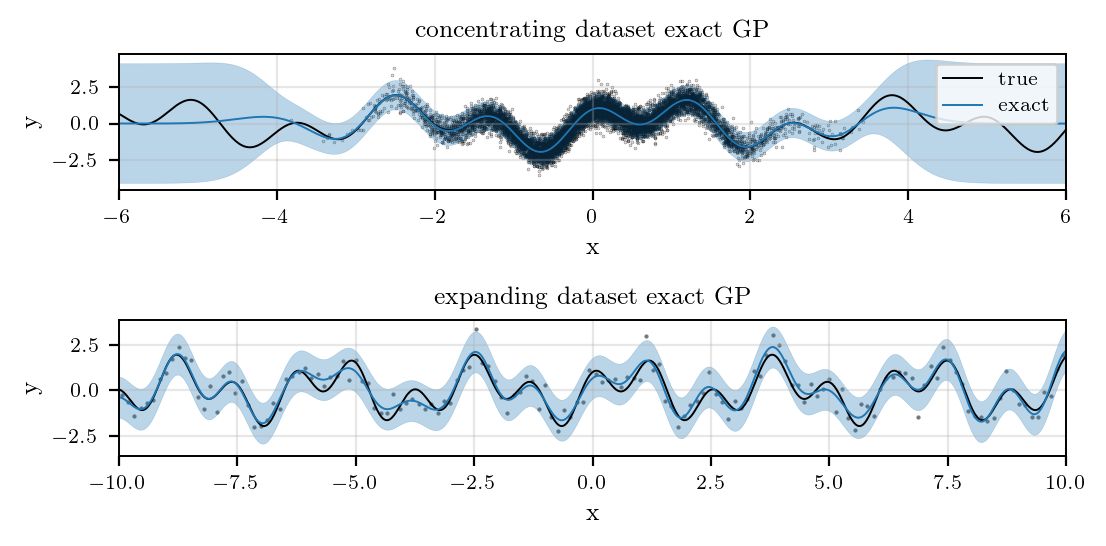

In [45]:


### view exact GP fits

fig, ax = plt.subplots(2,1, figsize=(text_width,text_width/2), dpi=200)

ax[0].scatter(concentrate_data_train.x, concentrate_data_train.y,  0.05, alpha=0.5, c='k')
ax[0].plot(concentrate_data_test.x, concentrate_data_test.y, alpha=1., c='k', linewidth=0.7, label='true')
errorfill(concentrate_data_test.x.squeeze(), concentrate_exact_pred_mean, 2*concentrate_exact_pred_std,
          color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[0],
              lw=0.7, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label='exact')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].grid(alpha=0.3)
ax[0].set_xlim([-6,6])
ax[0].legend()
ax[0].set_title('concentrating dataset exact GP')

ax[1].scatter(data_train.x, data_train.y,  0.3, alpha=0.5, c='k')
ax[1].plot(data_test.x, data_test.y, alpha=1., c='k', linewidth=0.7, label='true')
errorfill(data_test.x.squeeze(), exact_pred_mean, 2*exact_pred_std,
          color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[1],
              lw=0.7, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label='exact')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].grid(alpha=0.3)
ax[1].set_xlim([-10,10])
ax[1].set_title('expanding dataset exact GP')

plt.tight_layout()

# Sampling fits


### SGDGP

In [46]:

def info_to_dict(info, average_samples=True):
    keys = info[0].keys()

    training_results = {}

    for key in keys:
        result_vec = []
        for entry in info:
            if average_samples:
                result_vec.append(entry[key].mean(keepdims=True))
            else:
                result_vec.append(entry[key])
        training_results[key[1:]] = jnp.array(result_vec)
    return training_results

def plot_training_results(info):
    training_results = info_to_dict(info)
    num_entries = len(training_results.keys())
    fig, ax = plt.subplots(1,num_entries, dpi=200, figsize=(text_width,text_width/3))
    for i, key in enumerate(training_results.keys()):
        ax[i].plot(training_results[key])
        ax[i].set_yscale('log')
        ax[i].grid(alpha=0.3)
        ax[i].set_title(key)
    plt.tight_layout()
    plt.show()

### config

## create inducing dataset

In [47]:
from scalable_gps.data import Dataset

def get_inducing_dataset(dataset, inducing_points):
    assert dataset.x.shape[-1] == inducing_points.shape[-1]
    dataset = dataset._asdict()
    dataset['z'] =  inducing_points # concentrate_data_train['x'] #
    dataset = Dataset(**dataset)
    return dataset


## exact inducing posterior

In [48]:
from scalable_gps.kernels import featurise

num_samples = 500
n_features = 3000
key = jax.random.PRNGKey(0)
params_key, w_key, noise_key = jax.random.split(key, 3)
feature_params = concentrate_kernel.feature_params(params_key, n_features=n_features, x=concentrate_data_train.x)
w = jax.random.normal(w_key, shape=(n_features, num_samples))
eps = jax.random.normal(w_key, shape=(len(concentrate_data_train.x), num_samples)) * noise_scale

f0x = featurise(concentrate_data_train.x, feature_params) @ w

f0_test = featurise(concentrate_data_test.x, feature_params) @ w

N_inducing = 20
i_min = concentrate_data_train.x.min()
i_max = concentrate_data_train.x.max()
inducing_points = jnp.linspace(i_min, i_max, N_inducing)[..., None]
concentrate_data_train = get_inducing_dataset(concentrate_data_train, inducing_points)

Kxz = concentrate_kernel.kernel_fn(concentrate_data_train.x, concentrate_data_train.z)

Kzz = concentrate_kernel.kernel_fn(concentrate_data_train.z, concentrate_data_train.z)

# this is the high dimensional version

# tK = Kxz @ jax.scipy.linalg.solve(Kzz + jnp.eye(N_inducing)*1e-5, Kxz.T, assume_a='pos')

# targets = (f0x + eps)
# representer_weights = jax.scipy.linalg.solve(tK + jnp.eye(tK.shape[0])* noise_scale**2, targets, assume_a='pos')
# representer_MAP = jax.scipy.linalg.solve(tK + jnp.eye(tK.shape[0])* noise_scale**2, concentrate_data_train.y, assume_a='pos')

# Ktx = concentrate_kernel.kernel_fn(concentrate_data_test.x, concentrate_data_train.x)
# posterior_0_mean_functions = f0_test - Ktx @ representer_weights
# posterior_std = ((posterior_0_mean_functions ** 2).mean(axis=-1) + noise_scale**2 )**0.5
# posterior_MAP = Ktx @  representer_MAP



AttributeError: 'Dataset' object has no attribute '_asdict'

In [11]:
projected_noise = Kxz.T @ (f0x + eps) * (noise_scale**-2)
projected_targets = Kxz.T @ (concentrate_data_train.y) * (noise_scale**-2)
hessian = Kxz.T @ Kxz * (noise_scale**-2) + Kzz# + jnp.eye(N_inducing) * 5e-1

representer_MAP = jax.scipy.linalg.solve(hessian, projected_targets , assume_a='pos')
representer_weights = jax.scipy.linalg.solve(hessian, projected_noise , assume_a='pos')

Ktz = concentrate_kernel.kernel_fn(concentrate_data_test.x, concentrate_data_train.z)
posterior_0_mean_functions = f0_test - Ktz @ representer_weights
posterior_std = ((posterior_0_mean_functions ** 2).mean(axis=-1) + noise_scale**2 )**0.5
posterior_MAP = Ktz @  representer_MAP


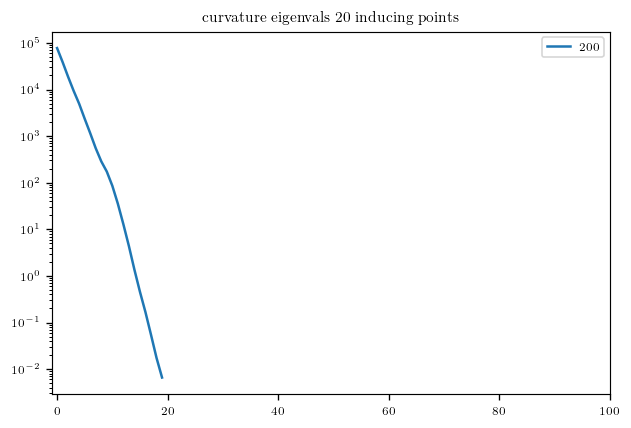

In [12]:
eig200 = jnp.linalg.eigvalsh(hessian)

plt.figure(dpi=120)
# plt.plot(eig20[::-1], label='20')
plt.plot(eig200[::-1], label='200')
plt.yscale('log')
plt.title(f'curvature eigenvals {N_inducing} inducing points')
plt.xlim([-1,100])
plt.legend()


In [13]:
# representer_MAP

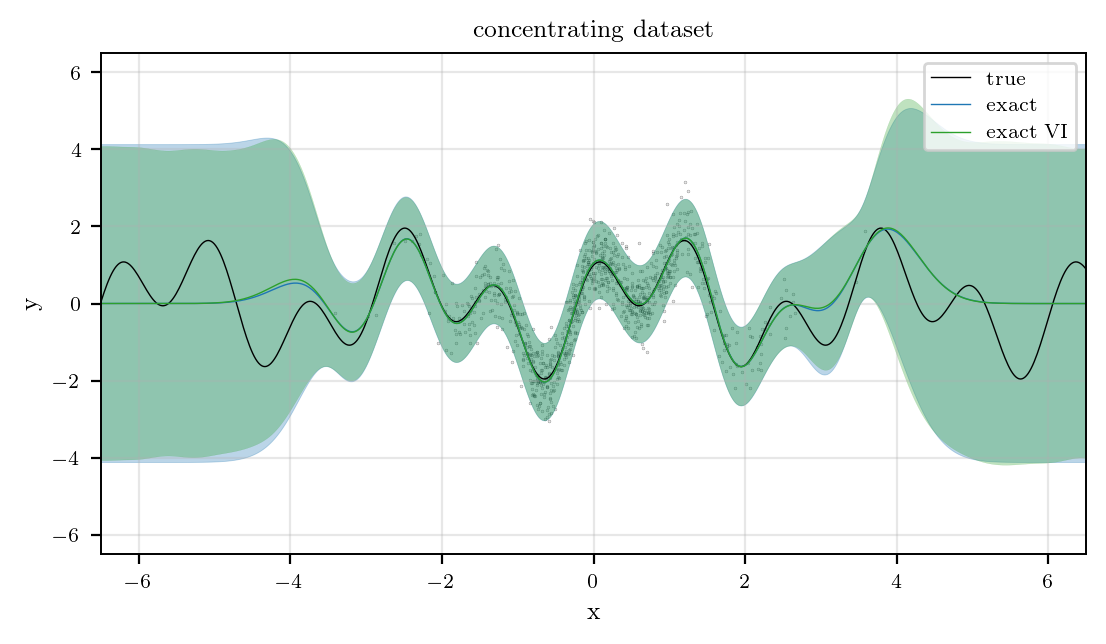

In [14]:


fig, ax = plt.subplots(1,1, figsize=(text_width,text_width/1.7), dpi=200)
ax = [ax]

ax[0].scatter(concentrate_data_train.x, concentrate_data_train.y,  0.03, alpha=0.5, c='k')
ax[0].plot(concentrate_data_test.x, concentrate_data_test.y, alpha=1., c='k', linewidth=0.5, label='true')

errorfill(concentrate_data_test.x.squeeze(), concentrate_exact_pred_mean, 2*concentrate_exact_pred_std,
          color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[0],
              lw=0.5, linestyle='-', fill_linewidths=0.3, marker=None, markersize=1, label='exact')


# ax[0].scatter(inducing_points, jnp.zeros(len(inducing_points)), 3, c=c[1], label='induing')


errorfill(concentrate_data_test.x.squeeze(), posterior_MAP, 2*posterior_std,
          color=c[2], alpha_fill=0.3, line_alpha=1, ax=ax[0],
              lw=0.5, linestyle='-', fill_linewidths=0.1, marker=None, markersize=1, label='exact VI')


ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].grid(alpha=0.3)
ax[0].set_xlim([-6.5,6.5])
ax[0].set_ylim([-6.5,6.5])
ax[0].legend()
ax[0].set_title('concentrating dataset')

plt.tight_layout()


In [15]:
representer_MAP.shape

(20,)

In [16]:

# n_features = 1000
# Kxx = concentrate_kernel.kernel_fn(concentrate_data_train.x, concentrate_data_train.x)

# key = jax.random.PRNGKey(0)
# params_key, w_key, noise_key = jax.random.split(key, 3)
# feature_params = concentrate_kernel.feature_params(params_key, n_features=n_features, x=concentrate_data_train.x)

# phix = featurise(concentrate_data_train.x, feature_params)
# phiz = featurise(concentrate_data_train.z, feature_params)

# approx_kzx = phix @ phiz.T
# approx_kxx = phix @ phix.T

# fig, ax = plt.subplots(1,2, dpi=120)
# ax[0].imshow(Kxz)
# ax[1].imshow(approx_kzx)


In [17]:
# print( ((Kxz - approx_kzx)**2).mean() / (Kxz**2).mean(), ((Kxx - approx_kxx)**2).mean()/ (Kxx**2).mean())



In [18]:

from scalable_gps.utils import ExactPredictionsTuple

concentrate_exact_metrics = ExactPredictionsTuple(
                alpha=representer_MAP, y_pred_loc=posterior_MAP)



### config

In [19]:
config = ml_collections.ConfigDict()
config.train_config = ml_collections.ConfigDict()

config.train_config.iterations = 5000
config.train_config.batch_size = 500
config.train_config.eval_every = 100

# RFF Configs
config.train_config.n_features_optim = 100
config.train_config.recompute_features = True

# Optimisation Configs
config.train_config.iterative_idx = True
config.train_config.learning_rate = 0.1
config.train_config.momentum = 0.9
config.train_config.nesterov = True
config.train_config.time_budget_in_seconds = -1
config.train_config.eval_every_in_seconds = None

polyak_k = 50
polyak_step = polyak_k / config.train_config.iterations
print('polyak_step', polyak_step)
config.train_config.polyak = polyak_step

config.train_config.absolute_clipping = 0.1  # -1 to avoid clipping

config.train_config.lr_schedule_name = None # "linear_schedule"
config.train_config.lr_schedule_config = ml_collections.ConfigDict()


# sampling 

config.sampling_config = ml_collections.ConfigDict()

config.sampling_config = config.train_config.copy_and_resolve_references()
config.sampling_config.n_samples = 100
# Full-batch training configs that get passed
config.sampling_config.iterative_idx = True
config.sampling_config.learning_rate = 2e-5
config.sampling_config.momentum = 0.9
config.sampling_config.iterations = 10000
config.sampling_config.batch_size = 500
config.sampling_config.absolute_clipping = 0.1  # -1 to avoid clipping


config.sampling_config.eval_every = 100 # eval every how many number of steps 

polyak_k = 50
polyak_step = polyak_k / config.sampling_config.iterations
print('polyak_step', polyak_step)
config.sampling_config.polyak = polyak_step


# RFF Configs
config.sampling_config.n_features_prior_sample = 100
config.sampling_config.n_features_optim = 100
config.sampling_config.recompute_features = True
config.sampling_config.loss_objective = 1
# config.sampling_config.use_cholesky_prior_sample = False


config.train_config.time_budget_in_seconds = -1
config.train_config.eval_every_in_seconds = None

metrics_list = ["loss", "err", "reg",  "test_rmse"] # 
metrics_list_MAP = ["loss",  "test_rmse", "alpha_diff", "alpha_rkhs_diff", "y_pred_diff"] # 


polyak_step 0.01
polyak_step 0.005


In [20]:

optim_key = jax.random.PRNGKey(0)


#### concetrate

In [21]:
N_inducing = 20
i_min = concentrate_data_train.x.min()
i_max = concentrate_data_train.x.max()
inducing_points = jnp.linspace(i_min, i_max, N_inducing)[..., None]
concentrate_data_train = get_inducing_dataset(concentrate_data_train, inducing_points)


100%|█████████████████████████████████| 100000/100000 [00:42<00:00, 2330.09it/s]


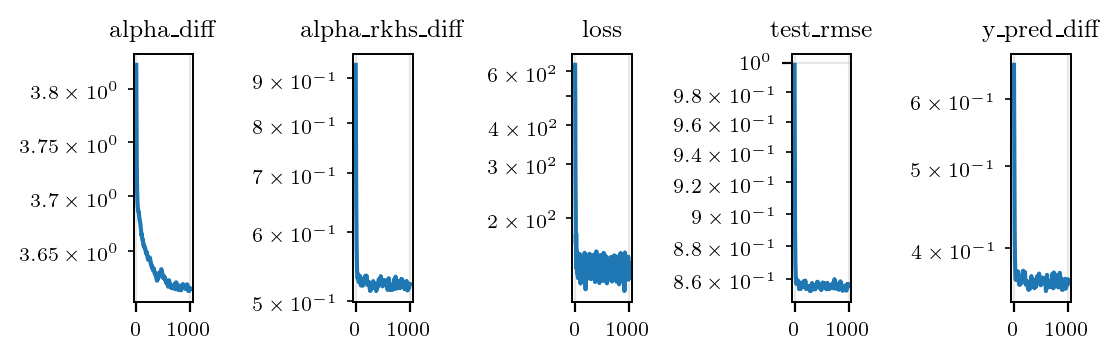

100%|█████████████████████████████████| 100000/100000 [00:49<00:00, 2032.64it/s]


zero_mean_samples : (100, 1000)
alpha_samples : (100, 20)


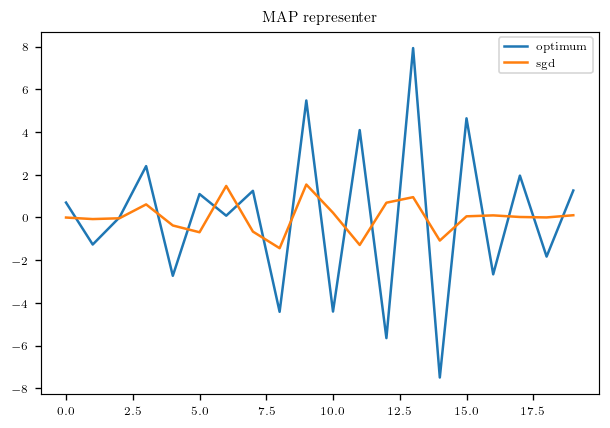

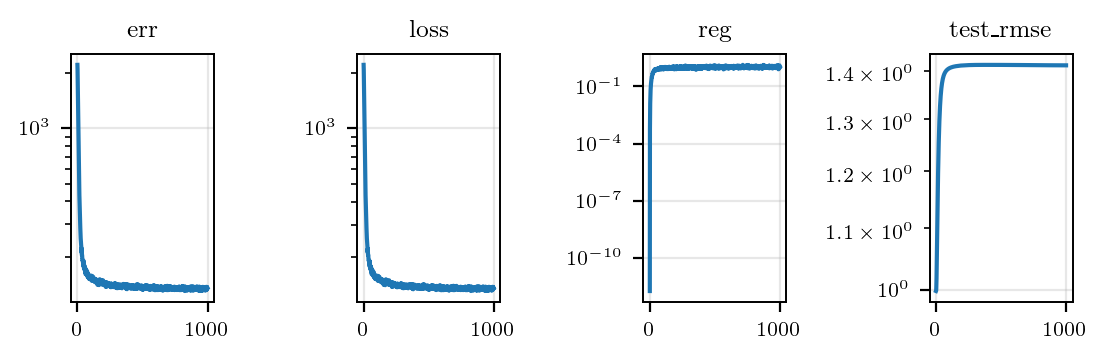

In [27]:


polyak_k = 100

config.train_config.learning_rate = 0.1
config.train_config.iterations = 100000

config.sampling_config.learning_rate = 1e-4
config.sampling_config.iterations =100000

config.sampling_config.polyak = polyak_k / config.sampling_config.iterations
config.train_config.polyak = polyak_k / config.train_config.iterations


config.sampling_config.n_samples = 100

concentrate_isgd_gp = ISGDGPModel(noise_scale=noise_scale, kernel=concentrate_kernel)



# MAP
concentrate_alpha_polyak, info = concentrate_isgd_gp.compute_representer_weights(
    key=optim_key,
    train_ds=concentrate_data_train, 
    test_ds=concentrate_data_test,
    config=config.train_config,
    metrics_list=metrics_list_MAP,
    exact_metrics=concentrate_exact_metrics,#concentrate_exact_metrics  # exact_metrics
)

concentrate_isgd_pred_mean = concentrate_isgd_gp.predictive_mean(concentrate_data_train, concentrate_data_test)
plot_training_results(info)


plt.figure(dpi=120)
plt.plot(representer_MAP, label='optimum')
plt.plot(concentrate_alpha_polyak, label='sgd')
plt.title('MAP representer')
plt.legend()


# sampling

concentrate_zero_mean_samples, concentrate_alpha_samples, concentrate_w_samples, info = concentrate_isgd_gp.compute_posterior_samples(
                                        optim_key, 
                                        n_samples=config.sampling_config.n_samples,
                                        train_ds=concentrate_data_train,
                                        test_ds=concentrate_data_test,
                                        config=config.sampling_config,
                                        use_rff=True,
                                        n_features=config.sampling_config.n_features_prior_sample,
                                        metrics_list = metrics_list,
                                        compare_exact=False,  # allows diff metrics with exact GP
                                    )
concentrate_isgd_pred_var_samples = concentrate_isgd_gp.predictive_variance_samples(concentrate_zero_mean_samples) + noise_scale ** 2
concentrate_isgd_pred_std_samples = jnp.sqrt(concentrate_isgd_pred_var_samples)

print(f'zero_mean_samples : {concentrate_zero_mean_samples.shape}')
print(f'alpha_samples : {concentrate_alpha_samples.shape}')

plot_training_results(info)



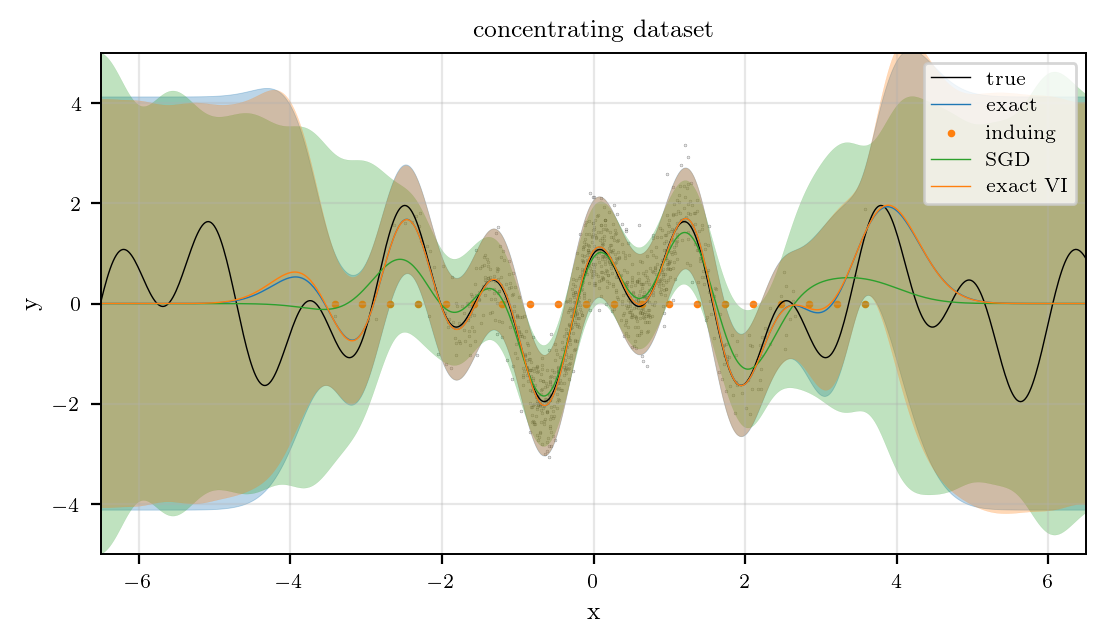

In [29]:
fig, ax = plt.subplots(1,1, figsize=(text_width,text_width/1.7), dpi=200)
ax = [ax]

ax[0].scatter(concentrate_data_train.x, concentrate_data_train.y,  0.03, alpha=0.5, c='k')
ax[0].plot(concentrate_data_test.x, concentrate_data_test.y, alpha=1., c='k', linewidth=0.5, label='true')

errorfill(concentrate_data_test.x.squeeze(), concentrate_exact_pred_mean, 2*concentrate_exact_pred_std,
          color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[0],
              lw=0.5, linestyle='-', fill_linewidths=0.3, marker=None, markersize=1, label='exact')


ax[0].scatter(inducing_points, jnp.zeros(len(inducing_points)), 3, c=c[1], label='induing')


errorfill(concentrate_data_test.x.squeeze(), concentrate_isgd_pred_mean, 2*concentrate_isgd_pred_std_samples,
          color=c[2], alpha_fill=0.3, line_alpha=1, ax=ax[0],
              lw=0.5, linestyle='-', fill_linewidths=0.1, marker=None, markersize=1, label='SGD')

# plt.plot(concentrate_data_test.x.squeeze(), concentrate_isgd_pred_mean, label='VI SGD', c=c[2], lw=1)

errorfill(concentrate_data_test.x.squeeze(), posterior_MAP, 2*posterior_std,
          color=c[1], alpha_fill=0.3, line_alpha=1, ax=ax[0],
              lw=0.5, linestyle='-', fill_linewidths=0.1, marker=None, markersize=1, label='exact VI')


ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].grid(alpha=0.3)
ax[0].set_xlim([-6.5,6.5])
ax[0].set_ylim([-5,5])
ax[0].legend()
ax[0].set_title('concentrating dataset')




plt.tight_layout()

## spread dataset

100%|███████████████████████████████████| 10000/10000 [00:04<00:00, 2062.23it/s]


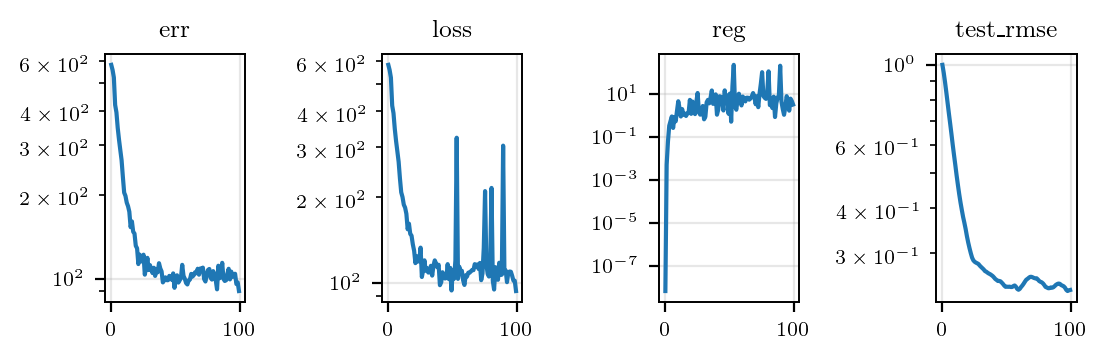

100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1926.67it/s]


zero_mean_samples : (50, 1000)
alpha_samples : (50, 300)


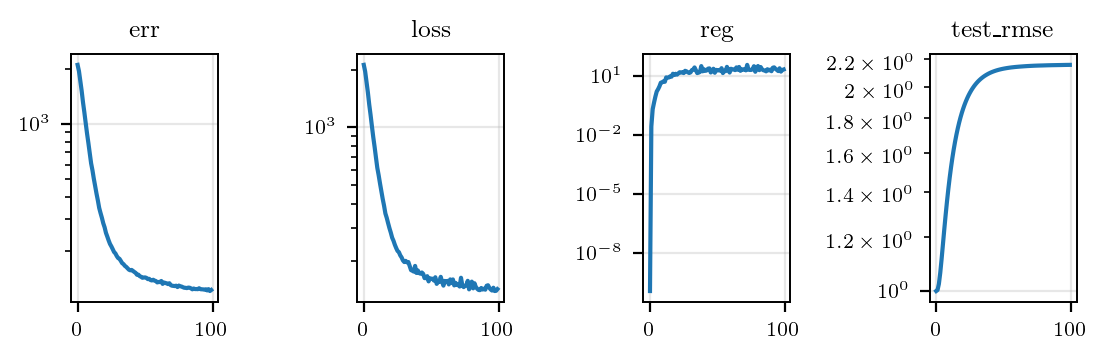

In [42]:

config.train_config.learning_rate = 0.5
config.train_config.iterations = 10000


config.sampling_config.learning_rate = 5e-3
config.sampling_config.iterations = 10000
config.sampling_config.n_samples = 50

isgd_gp = ISGDGPModel(noise_scale=noise_scale, kernel=kernel)

N_inducing = 300
inducing_points = jnp.linspace(data_train.x.min(), data_train.x.max(), N_inducing)[..., None]
data_train = get_inducing_dataset(data_train, inducing_points)


# MAP
alpha_polyak, info = isgd_gp.compute_representer_weights(
    key=optim_key,
    train_ds=data_train, 
    test_ds=data_test,
    config=config.train_config,
    metrics_list=metrics_list,
    exact_metrics=None,  # exact_metrics
)

isgd_pred_mean = isgd_gp.predictive_mean(data_train, data_test)
plot_training_results(info)


zero_mean_samples, alpha_samples, concentrate_w_samples, info = isgd_gp.compute_posterior_samples(
                                        optim_key, 
                                        n_samples=config.sampling_config.n_samples,
                                        train_ds=data_train,
                                        test_ds=data_test,
                                        config=config.sampling_config,
                                        use_rff=True,
                                        n_features=config.sampling_config.n_features_prior_sample,
                                        metrics_list = metrics_list,
                                        compare_exact=False,  # allows diff metrics with exact GP
                                    )
isgd_pred_var_samples = isgd_gp.predictive_variance_samples(zero_mean_samples) + noise_scale ** 2
isgd_pred_std_samples = jnp.sqrt(isgd_pred_var_samples)

print(f'zero_mean_samples : {zero_mean_samples.shape}')
print(f'alpha_samples : {alpha_samples.shape}')

plot_training_results(info)



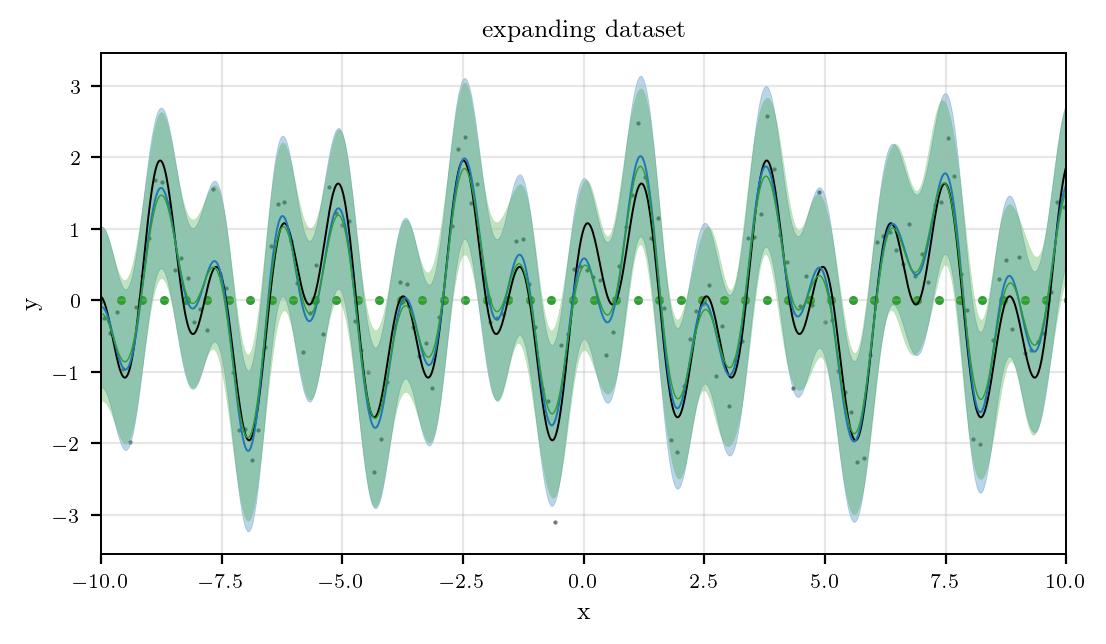

In [43]:
fig, ax = plt.subplots(1,1, figsize=(text_width,text_width/1.7), dpi=200)

ax = [ax]






ax[0].scatter(data_train.x, data_train.y,  0.3, alpha=0.5, c='k')
ax[0].plot(data_test.x, data_test.y, alpha=1., c='k', linewidth=0.7, label='true')
errorfill(data_test.x.squeeze(), exact_pred_mean, 2*exact_pred_std,
          color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[0],
              lw=0.7, linestyle='-', fill_linewidths=0.3, marker=None, markersize=1, label='exact')



ax[0].scatter(inducing_points, jnp.zeros(len(inducing_points)), 5, c=c[2])

errorfill(data_test.x.squeeze(), isgd_pred_mean, 2*isgd_pred_std_samples,
          color=c[2], alpha_fill=0.3, line_alpha=1, ax=ax[0],
              lw=0.5, linestyle='-', fill_linewidths=0.1, marker=None, markersize=1, label='sampling')


ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].grid(alpha=0.3)
ax[0].set_xlim([-10,10])
ax[0].set_title('expanding dataset')

plt.tight_layout()

## test annoy on concentrate data

In [49]:
from scalable_gps.knn import annoy_cluster_dataset

In [78]:
set(np.ones(3))

{1.0}

In [126]:
wigle_length =  concentratre_kernel_config['length_scale'][0] ** 0.5 / 2

print(wigle_length)


0.35355335


In [133]:
import time
tic = time.time()
concentrate_data_train = annoy_cluster_dataset(concentrate_data_train, n_trees=50, num_neighbours=100,
                                   max_dist=wigle_length, savefile='./concentrate.ann', recompute=True)

toc = time.time()

print(toc - tic)


created index
loaded data
built model
saved model
created pair dict
obtained 210 non-pruned indices
33.77933740615845


(array([0.01342555, 0.02685109, 0.        , 0.04027661, 0.02685109,
        0.06712773, 0.10740437, 0.2148087 , 0.26851092, 0.32221305,
        0.38934081, 0.37591526, 0.34906414, 0.24165983, 0.18795765,
        0.09397879, 0.04027662, 0.01342555, 0.02685109, 0.01342555]),
 array([-3.82108188, -3.46639204, -3.1117022 , -2.75701237, -2.40232229,
        -2.04763246, -1.69294262, -1.33825278, -0.98356289, -0.62887305,
        -0.27418315,  0.08050672,  0.43519658,  0.78988647,  1.14457631,
         1.49926615,  1.8539561 ,  2.20864606,  2.5633359 ,  2.91802573,
         3.27271557]),
 <BarContainer object of 20 artists>)

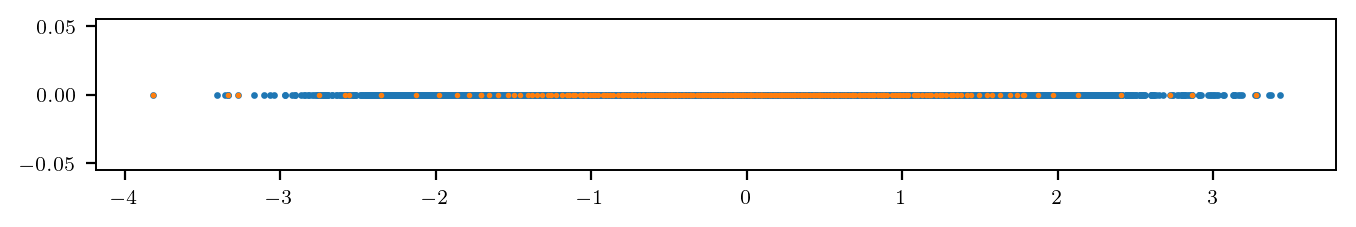

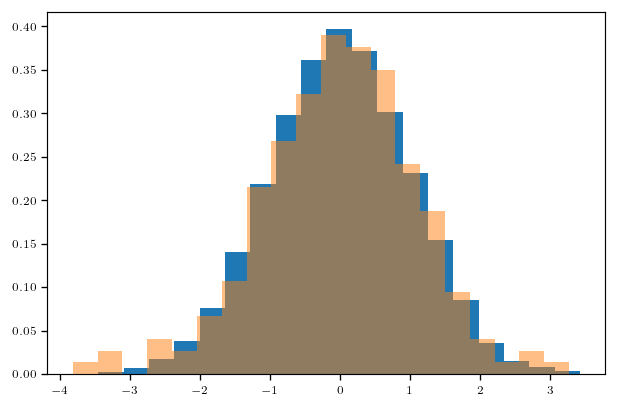

In [136]:

plt.figure(dpi=200, figsize=(8,1))
plt.scatter(concentrate_data_train.x, jnp.zeros(len(concentrate_data_train.x)), 2)
plt.scatter(concentrate_data_train.z, jnp.zeros(len(concentrate_data_train.z)), 1)

plt.figure(dpi=120)
plt.hist(concentrate_data_train.x[:,0], 20, density=True)
plt.hist(concentrate_data_train.z[:,0], 20, density=True, alpha=0.5)


In [141]:
config = ml_collections.ConfigDict()
config.train_config = ml_collections.ConfigDict()

config.train_config.iterations = 5000
config.train_config.batch_size = 500
config.train_config.eval_every = 100

# RFF Configs
config.train_config.n_features_optim = 100
config.train_config.recompute_features = True

# Optimisation Configs
config.train_config.iterative_idx = True
config.train_config.learning_rate = 0.1
config.train_config.momentum = 0.9
config.train_config.nesterov = True
config.train_config.time_budget_in_seconds = -1
config.train_config.eval_every_in_seconds = None

polyak_k = 50
polyak_step = polyak_k / config.train_config.iterations
print('polyak_step', polyak_step)
config.train_config.polyak = polyak_step

config.train_config.absolute_clipping = 0.1  # -1 to avoid clipping

config.train_config.lr_schedule_name = None # "linear_schedule"
config.train_config.lr_schedule_config = ml_collections.ConfigDict()


# sampling 

config.sampling_config = ml_collections.ConfigDict()

config.sampling_config = config.train_config.copy_and_resolve_references()
config.sampling_config.n_samples = 100
# Full-batch training configs that get passed
config.sampling_config.iterative_idx = True
config.sampling_config.learning_rate = 2e-5
config.sampling_config.momentum = 0.9
config.sampling_config.iterations = 10000
config.sampling_config.batch_size = 500
config.sampling_config.absolute_clipping = 0.1  # -1 to avoid clipping


config.sampling_config.eval_every = 100 # eval every how many number of steps 

polyak_k = 50
polyak_step = polyak_k / config.sampling_config.iterations
print('polyak_step', polyak_step)
config.sampling_config.polyak = polyak_step


# RFF Configs
config.sampling_config.n_features_prior_sample = 100
config.sampling_config.n_features_optim = 100
config.sampling_config.recompute_features = True
config.sampling_config.loss_objective = 1
# config.sampling_config.use_cholesky_prior_sample = False


config.train_config.time_budget_in_seconds = -1
config.train_config.eval_every_in_seconds = None

metrics_list = ["loss", "err", "reg",  "test_rmse"] # 
metrics_list_MAP = ["loss",  "test_rmse", "alpha_diff", "alpha_rkhs_diff", "y_pred_diff"] # 


polyak_step 0.01
polyak_step 0.005


100%|██████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1727.81it/s]


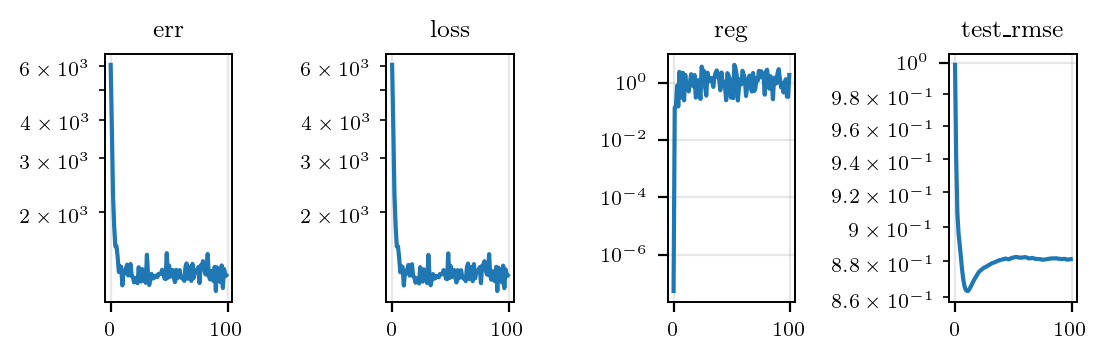

100%|██████████████████████████████████████████████████████████████| 20000/20000 [00:11<00:00, 1768.31it/s]


zero_mean_samples : (300, 1000)
alpha_samples : (300, 210)


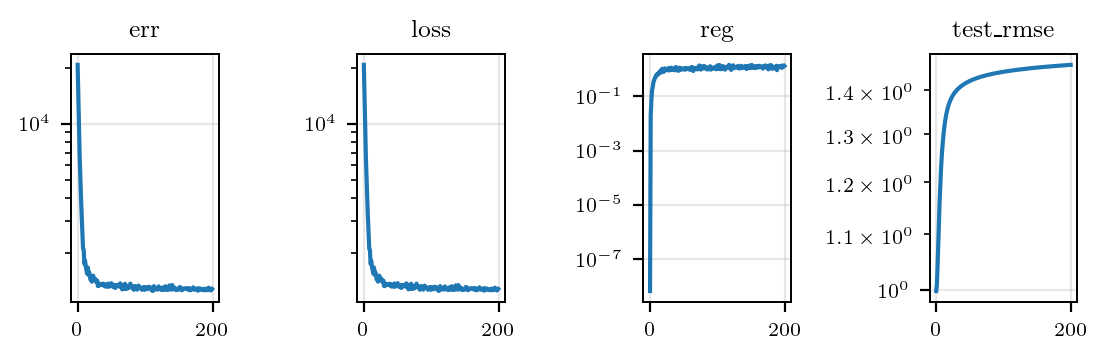

In [142]:
optim_key = jax.random.PRNGKey(0)

polyak_k = 50

config.train_config.learning_rate = 0.05
config.train_config.iterations = 10000

config.sampling_config.learning_rate = 1e-4
config.sampling_config.iterations =20000

config.sampling_config.polyak = polyak_k / config.sampling_config.iterations
config.train_config.polyak = polyak_k / config.train_config.iterations


config.sampling_config.n_samples = 300

concentrate_isgd_gp = ISGDGPModel(noise_scale=noise_scale, kernel=concentrate_kernel)



# MAP
concentrate_alpha_polyak, info = concentrate_isgd_gp.compute_representer_weights(
    key=optim_key,
    train_ds=concentrate_data_train, 
    test_ds=concentrate_data_test,
    config=config.train_config,
    metrics_list=metrics_list,
    exact_metrics=None,#concentrate_exact_metrics  # exact_metrics
)

concentrate_isgd_pred_mean = concentrate_isgd_gp.predictive_mean(concentrate_data_train, concentrate_data_test)
plot_training_results(info)


# sampling

concentrate_zero_mean_samples, concentrate_alpha_samples, concentrate_w_samples, info = concentrate_isgd_gp.compute_posterior_samples(
                                        optim_key, 
                                        n_samples=config.sampling_config.n_samples,
                                        train_ds=concentrate_data_train,
                                        test_ds=concentrate_data_test,
                                        config=config.sampling_config,
                                        use_rff=True,
                                        n_features=config.sampling_config.n_features_prior_sample,
                                        metrics_list = metrics_list,
                                        compare_exact=False,  # allows diff metrics with exact GP
                                    )
concentrate_isgd_pred_var_samples = concentrate_isgd_gp.predictive_variance_samples(concentrate_zero_mean_samples) + noise_scale ** 2
concentrate_isgd_pred_std_samples = jnp.sqrt(concentrate_isgd_pred_var_samples)

print(f'zero_mean_samples : {concentrate_zero_mean_samples.shape}')
print(f'alpha_samples : {concentrate_alpha_samples.shape}')

plot_training_results(info)



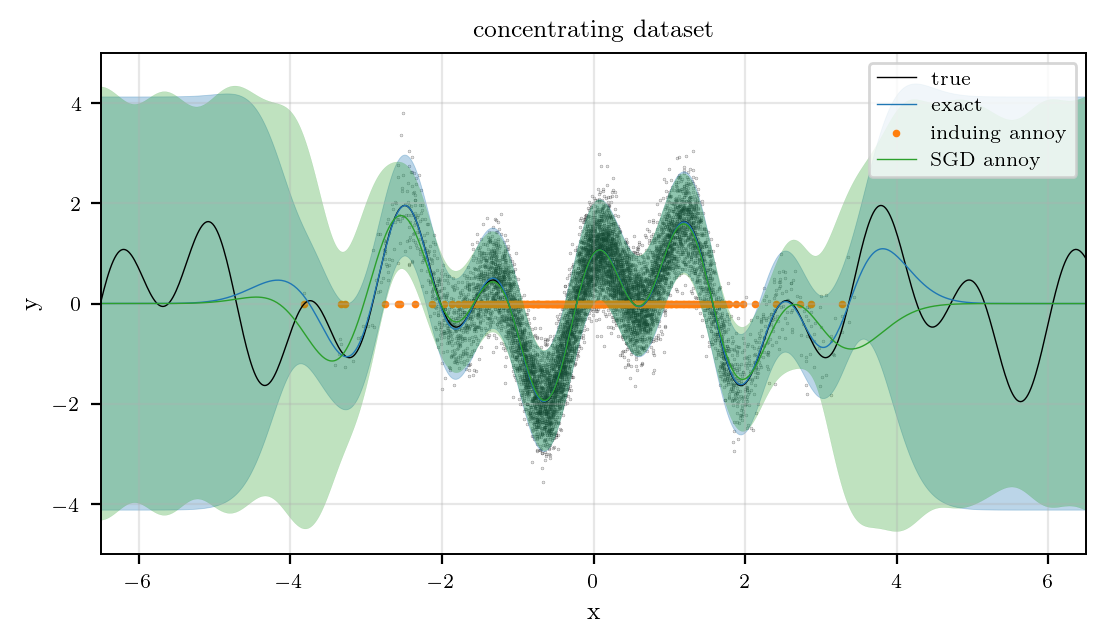

In [143]:
fig, ax = plt.subplots(1,1, figsize=(text_width,text_width/1.7), dpi=200)
ax = [ax]

ax[0].scatter(concentrate_data_train.x, concentrate_data_train.y,  0.03, alpha=0.5, c='k')
ax[0].plot(concentrate_data_test.x, concentrate_data_test.y, alpha=1., c='k', linewidth=0.5, label='true')

errorfill(concentrate_data_test.x.squeeze(), concentrate_exact_pred_mean, 2*concentrate_exact_pred_std,
          color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[0],
              lw=0.5, linestyle='-', fill_linewidths=0.3, marker=None, markersize=1, label='exact')


ax[0].scatter(concentrate_data_train.z.squeeze(), jnp.zeros(len(concentrate_data_train.z)), 3, c=c[1], label='induing annoy')


errorfill(concentrate_data_test.x.squeeze(), concentrate_isgd_pred_mean, 2*concentrate_isgd_pred_std_samples,
          color=c[2], alpha_fill=0.3, line_alpha=1, ax=ax[0],
              lw=0.5, linestyle='-', fill_linewidths=0.1, marker=None, markersize=1, label='SGD annoy')



ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].grid(alpha=0.3)
ax[0].set_xlim([-6.5,6.5])
ax[0].set_ylim([-5,5])
ax[0].legend()
ax[0].set_title('concentrating dataset')




plt.tight_layout()

## large dataset|

In [150]:
from scalable_gps.data import get_dataset


he_train, he_test = get_dataset('houseelectric', split=0)


houseelectric dataset, N=2049280, d=11


## kmeans (slow past 1000 centroids)

In [147]:
# from scalable_gps.kmeans import kmeans, centroids_counts

# key = jax.random.PRNGKey(0)

# num_inducing = 1000

# z, _ = kmeans(key, large_train.x[::], k=num_inducing, thresh=1e-1)
# raw_counts = centroids_counts(large_train.x, z)
# # z = z[raw_counts > 0]

# # print(raw_counts)


## annoy clustering

In [176]:
from scalable_gps.knn import annoy_cluster_dataset

In [153]:
lengthscales = jnp.array([2.3603036 ,  2.0089    ,  5.771779  ,  1.9287668 ,  8.034236  ,
        2.8651323 , 11.73      ,  0.56991285,  7.5436516 , 10.031956  ,
        9.574515 ])



In [ ]:
import time
lengthscales = jnp.array([2.3603036 ,  2.0089    ,  5.771779  ,  1.9287668 ,  8.034236  ,
        2.8651323 , 11.73      ,  0.56991285,  7.5436516 , 10.031956  ,
        9.574515 ])
max_dist = np.percentile(lengthscales**2, 25) / 2 #lengthscales.mean() / 2
print(f'{max_dist=}')

tic = time.time()
he_train_z = annoy_cluster_dataset(he_train, n_trees=50, num_neighbours=50,
                                   max_dist=max_dist, savefile='./he_annoy.ann', recompute=True)
toc = time.time()
print('time', toc-tic)


max_dist=2.4016780853271484
created index
loaded data
built model
saved model


In [ ]:
toc - tic

In [180]:
from scalable_gps.kernels import Matern32Kernel
he_kernel_config = {
    'signal_scale': jnp.array([0.2374456375837326]),
    'length_scale': lengthscales,
}
he_noise_scale = 0.00647840416058898


he_kernel = Matern32Kernel(kernel_config=he_kernel_config)




## train inducing SGD

In [186]:
config = ml_collections.ConfigDict()
config.train_config = ml_collections.ConfigDict()

config.train_config.iterations = 5000
config.train_config.batch_size = 50
config.train_config.eval_every = 1000

# RFF Configs
config.train_config.n_features_optim = 100
config.train_config.recompute_features = True

# Optimisation Configs
config.train_config.iterative_idx = True
config.train_config.learning_rate = 0.1
config.train_config.momentum = 0.9
config.train_config.nesterov = True
config.train_config.time_budget_in_seconds = -1
config.train_config.eval_every_in_seconds = None

polyak_k = 50
polyak_step = polyak_k / config.train_config.iterations
print('polyak_step', polyak_step)
config.train_config.polyak = polyak_step

config.train_config.absolute_clipping = 0.1  # -1 to avoid clipping

config.train_config.lr_schedule_name = None # "linear_schedule"
config.train_config.lr_schedule_config = ml_collections.ConfigDict()


# sampling 

# config.sampling_config = ml_collections.ConfigDict()

# config.sampling_config = config.train_config.copy_and_resolve_references()
# config.sampling_config.n_samples = 100
# # Full-batch training configs that get passed
# config.sampling_config.iterative_idx = True
# config.sampling_config.learning_rate = 2e-5
# config.sampling_config.momentum = 0.9
# config.sampling_config.iterations = 10000
# config.sampling_config.batch_size = 500
# config.sampling_config.absolute_clipping = 0.1  # -1 to avoid clipping


# config.sampling_config.eval_every = 100 # eval every how many number of steps 

# polyak_k = 50
# polyak_step = polyak_k / config.sampling_config.iterations
# print('polyak_step', polyak_step)
# config.sampling_config.polyak = polyak_step


# # RFF Configs
# config.sampling_config.n_features_prior_sample = 100
# config.sampling_config.n_features_optim = 100
# config.sampling_config.recompute_features = True
# config.sampling_config.loss_objective = 1
# # config.sampling_config.use_cholesky_prior_sample = False


config.train_config.time_budget_in_seconds = -1
config.train_config.eval_every_in_seconds = None

metrics_list = ["loss", "err", "reg",  "test_rmse"] # 


polyak_step 0.01


In [187]:
optim_key = jax.random.PRNGKey(0)

polyak_k = 100

config.train_config.learning_rate = 0.1
config.train_config.iterations = 10000

# config.sampling_config.learning_rate = 1e-4
# config.sampling_config.iterations =100000

# config.sampling_config.polyak = polyak_k / config.sampling_config.iterations
config.train_config.polyak = polyak_k / config.train_config.iterations


# config.sampling_config.n_samples = 100

he_isgd_gp = ISGDGPModel(noise_scale=he_noise_scale, kernel=he_kernel)



# MAP
he_alpha_polyak, info = he_isgd_gp.compute_representer_weights(
    key=optim_key,
    train_ds=he_train_z, 
    test_ds=he_test,
    config=config.train_config,
    metrics_list=metrics_list,
    exact_metrics=None,#concentrate_exact_metrics  # exact_metrics
)

# he_isgd_pred_mean = concentrate_isgd_gp.predictive_mean(he_data_train, he_data_test)
plot_training_results(info)


2023-05-11 13:39:35.113992: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2410] Execution of replica 0 failed: INTERNAL: Failed to load in-memory CUBIN: CUDA_ERROR_OUT_OF_MEMORY: out of memory


XlaRuntimeError: INTERNAL: Failed to load in-memory CUBIN: CUDA_ERROR_OUT_OF_MEMORY: out of memory

In [ ]:

optim_key = jax.random.PRNGKey(0)
